
Matrix Size: 5x5
Number of non-zero off-diagonal element pairs: 5
Total number of non-zero elements: 15

Sparse Matrix Representation (row, column, value):
[1, 1, 1.5274]
[1, 2, -0.8872]
[1, 3, 0.4440]
[1, 5, 0.9844]
[2, 1, -0.8872]
[2, 2, 2.1036]
[2, 4, -0.9984]
[3, 1, 0.4440]
[3, 3, 1.8849]
[3, 5, 0.8771]
[4, 2, -0.9984]
[4, 4, 1.7515]
[5, 1, 0.9844]
[5, 3, 0.8771]
[5, 5, 1.3089]

Full Matrix Representation:
tensor([[ 1.5274, -0.8872,  0.4440,  0.0000,  0.9844],
        [-0.8872,  2.1036,  0.0000, -0.9984,  0.0000],
        [ 0.4440,  0.0000,  1.8849,  0.0000,  0.8771],
        [ 0.0000, -0.9984,  0.0000,  1.7515,  0.0000],
        [ 0.9844,  0.0000,  0.8771,  0.0000,  1.3089]])


Creating animation:   0%|          | 0/1000 [00:00<?, ?it/s]

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1200x600', '-pix_fmt', 'rgba', '-framerate', '30', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'eigenvalues_animation.mp4']' returned non-zero exit status 255.

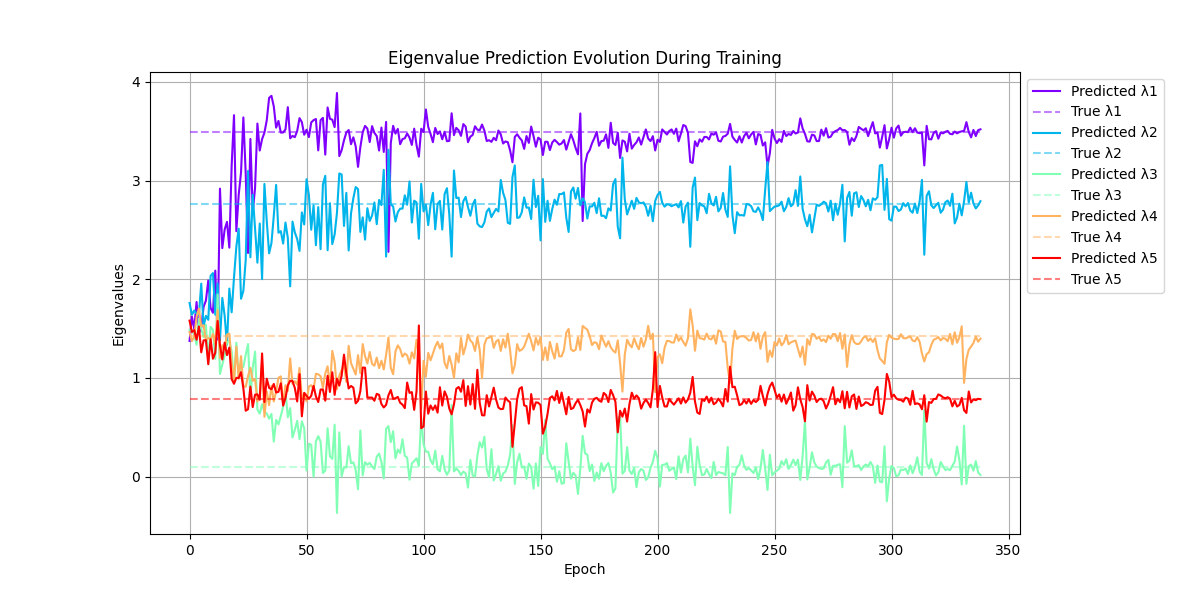

In [1]:
%matplotlib ipympl

import torch.nn as nn
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 1000
from tqdm.auto import tqdm
from IPython.display import HTML
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
plt.rcParams['animation.html'] = 'jshtml'
from matplotlib.animation import FuncAnimation

class SymmetricEigenvalueNet(nn.Module):
    def __init__(self,
                 matrix_size,
                 hidden_layers=[128, 256, 128]):
        super(SymmetricEigenvalueNet, self).__init__()
        input_size = (matrix_size * (matrix_size + 1)) // 2
        self.input_layer = nn.Linear(input_size, hidden_layers[0])
        self.input_norm = nn.LayerNorm(hidden_layers[0])
        self.hidden_layers = nn.ModuleList()

        for i in range(len(hidden_layers) - 1):
            self.hidden_layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
            self.hidden_layers.append(nn.LayerNorm(hidden_layers[i + 1]))
            self.hidden_layers.append(nn.ReLU())

        self.output_layer = nn.Linear(hidden_layers[-1], matrix_size)
        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, x):
        x_flat = self.extract_lower_triangular(x)
        x = self.input_layer(x_flat)
        x = self.input_norm(x)
        x = F.relu(x)

        for i in range(0, len(self.hidden_layers), 3):
            x = self.hidden_layers[i](x)
            x = self.hidden_layers[i + 1](x)
            x = self.hidden_layers[i + 2](x)

        return self.output_layer(x)

    @staticmethod
    def extract_lower_triangular(matrix):
        if matrix.dim() == 2:
            matrix = matrix.unsqueeze(0)
        batch_size, n, _ = matrix.shape
        mask = torch.tril(torch.ones(n, n, device=matrix.device, dtype=torch.bool))
        lower_tri = matrix[mask.repeat(batch_size, 1, 1)]
        return lower_tri.view(batch_size, -1)

def generate_symmetric_matrix(size=5, k=None, seed=42, sparse_format=False):
    """
    Generate a sparse symmetric matrix with k non-zero off-diagonal elements
    and guaranteed non-zero diagonal elements
    """
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Initialize zero matrix
    matrix = np.zeros((size, size))

    # First, set all diagonal elements
    for i in range(size):
        matrix[i, i] = np.random.uniform(1, 2)

    # Calculate maximum possible off-diagonal elements
    max_off_diag = (size * (size - 1)) // 2  # Only upper triangular, excluding diagonal

    if k is None:
        k = max_off_diag

    # Ensure k is not larger than possible off-diagonal elements
    k = min(k, max_off_diag)

    # Generate positions for off-diagonal elements only
    off_diag_positions = []
    for i in range(size):
        for j in range(i + 1, size):
            off_diag_positions.append((i, j))

    # Randomly select k positions
    selected_positions = np.random.choice(len(off_diag_positions), k, replace=False)

    # Fill the selected positions
    for pos_idx in selected_positions:
        i, j = off_diag_positions[pos_idx]
        val = np.random.uniform(-1, 1)
        matrix[i, j] = val
        matrix[j, i] = val  # Ensure symmetry

    # Add a positive constant to diagonal to ensure no zero eigenvalues
    min_eigenval = np.min(np.linalg.eigvals(matrix))
    if min_eigenval <= 0:
        shift = -min_eigenval + 0.1
        np.fill_diagonal(matrix, matrix.diagonal() + shift)

    if not sparse_format:
        return torch.tensor(matrix, dtype=torch.float32)

    # Convert to sparse format
    sparse_list = []
    for i in range(size):
        for j in range(size):
            if matrix[i, j] != 0:
                sparse_list.append([i + 1, j + 1, matrix[i, j]])
    return sparse_list

def print_matrix_representations(matrix_size, k=None, seed=42):
    # Generate both representations
    full_matrix = generate_symmetric_matrix(size=matrix_size, k=k, seed=seed, sparse_format=False)

    # Create sparse representation
    sparse_list = []
    for i in range(matrix_size):
        for j in range(matrix_size):
            if full_matrix[i][j] != 0:
                # Adding 1 to indices since we want 1-based indexing
                sparse_list.append([i + 1, j + 1, full_matrix[i][j].item()])

    # Print representations
    print(f"\nMatrix Size: {matrix_size}x{matrix_size}")
    print(f"Number of non-zero off-diagonal element pairs: {len([1 for x in sparse_list if x[0] != x[1]]) // 2}")
    print(f"Total number of non-zero elements: {len(sparse_list)}")

    print("\nSparse Matrix Representation (row, column, value):")
    for entry in sparse_list:
        print(f"[{int(entry[0])}, {int(entry[1])}, {entry[2]:.4f}]")

    print(f"\nFull Matrix Representation:")
    print(full_matrix)

def generate_true_eigenvalues(mat):
    return torch.tensor(np.linalg.eigvals(mat.numpy()), dtype=torch.float32)

def custom_eigenvalue_loss(predicted_eigenvalues,
                           true_batch_eigenvalues):
    return F.mse_loss(predicted_eigenvalues, true_batch_eigenvalues)

def create_animation(train_matrices,
                     true_eigenvalues,
                     test_matrix,
                     epochs=300,
                     batch_size=32,
                     filename='eigenvalues_animation.mp4'):
    model = SymmetricEigenvalueNet(matrix_size=train_matrices.shape[1])
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50)

    test_true_eigenvalues = generate_true_eigenvalues(test_matrix)

    fig = plt.figure(figsize=(12, 6))
    plt.subplots_adjust(right=0.85)
    ax = fig.add_subplot(111)

    colors = plt.cm.rainbow(np.linspace(0, 1, train_matrices.shape[1]))
    lines = []
    true_lines = []

    for i, color in enumerate(colors):
        line, = ax.plot([], [], label=f'Predicted λ{i + 1}', color=color)
        lines.append(line)
        true_line, = ax.plot([], [], '--', label=f'True λ{i + 1}', color=color, alpha=0.5)
        true_lines.append(true_line)

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Eigenvalues')
    ax.set_title('Eigenvalue Prediction Evolution During Training')
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

    epochs_list = []
    eigenvalues_history = []

    def init():
        for line in lines + true_lines:
            line.set_data([], [])
        return lines + true_lines

    progress_bar = tqdm(total=epochs, desc="Creating animation")

    def animate(frame):
        epoch = frame
        epoch_loss = 0.0
        model.train()

        train_dataset = torch.utils.data.TensorDataset(train_matrices, true_eigenvalues)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for batch_matrices, batch_eigenvalues in train_loader:
            optimizer.zero_grad()
            predicted_eigenvalues = model(batch_matrices)
            loss = custom_eigenvalue_loss(predicted_eigenvalues, batch_eigenvalues)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(train_loader)
        scheduler.step(avg_epoch_loss)

        model.eval()
        with torch.no_grad():
            test_pred = model(test_matrix.unsqueeze(0))[0]

        epochs_list.append(epoch)
        eigenvalues_history.append(test_pred.numpy())

        for i, line in enumerate(lines):
            line.set_data(epochs_list, [ev[i] for ev in eigenvalues_history])
            true_lines[i].set_data([0, epoch], [test_true_eigenvalues[i], test_true_eigenvalues[i]])

        progress_bar.update(1)
        ax.relim()
        ax.autoscale_view()
        return lines + true_lines

    anim = FuncAnimation(fig, animate, init_func=init, frames=epochs, interval=100, blit=True)

    # Save animation to MP4 file
    anim.save(filename, writer='ffmpeg', fps=30)
    plt.close()

    # Clear memory
    del train_matrices, true_eigenvalues, model, optimizer, scheduler
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

    # Display video with autoplay and loop
    return HTML(f"""
    <video width="800" height="400" controls autoplay loop>
        <source src="{filename}" type="video/mp4">
    </video>
    """)

# Usage example:
matrix_size = 5
num_nonzero = 5
num_train_matrices = matrix_size * 1000

# Print both matrix representations
print_matrix_representations(matrix_size=matrix_size,
                             k=num_nonzero,
                             seed=42)

# Generate training data
train_matrices = torch.stack([generate_symmetric_matrix(size=matrix_size,
                                                        k=num_nonzero,
                                                        seed=i)
                            for i in range(num_train_matrices)])
test_matrix = generate_symmetric_matrix(size=matrix_size,
                                        k=num_nonzero,
                                        seed=42)
true_eigenvalues = torch.stack([generate_true_eigenvalues(matrix) for matrix in train_matrices])

# Create and display animation
animation_display = create_animation(train_matrices, true_eigenvalues, test_matrix, epochs=1000)
display(animation_display)